In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from surprise import KNNWithMeans
from surprise import Dataset,Reader
from surprise.model_selection import train_test_split
from collections import defaultdict
from surprise import SVD
from surprise import accuracy
from scipy.sparse.linalg import svds
import copy

In [30]:
# print(os.listdir("../input"))

#### Load the data

In [31]:
user_rating_data = pd.read_csv('../input/ratings_Electronics.csv')

In [32]:
user_rating_data.columns = ['UserID','ProductID','Ratings','Timestamp']

In [33]:
user_rating_data.head()

,UserID,ProductID,Ratings,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


#### Draw histogram to get idea how data is distributed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d0bb88e90>,
      dtype=object)

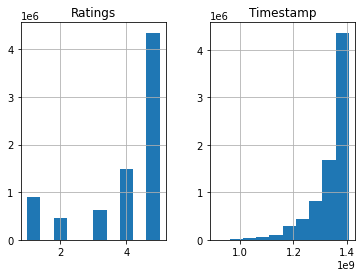

In [34]:
user_rating_data.hist()

##### Take subset of data

In [36]:
# Crate a subset of data with users who has given ratings more than 50 times
users_filter = user_rating_data['UserID'].value_counts()
usersfilter_df = pd.DataFrame(users_filter).reset_index()
usersfilter_df.columns = ['UserID','Count']
usersfilter_df_IDs = usersfilter_df[usersfilter_df['Count'] > 100]['UserID']
user_rating_data_Subset = user_rating_data[user_rating_data['UserID'].isin(usersfilter_df_IDs)]
user_rating_data_Subset

,UserID,ProductID,Ratings,Timestamp
117,AT09WGFUM934H,0594481813,3.0,1377907200
177,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
630,A3TAS1AG6FMBQW,0972683275,5.0,1353456000
1776,A18S2VGUH9SCV5,1400501776,4.0,1340755200
2161,A5JLAU2ARJ0BO,1400532655,1.0,1291334400
...,...,...,...,...
7824425,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0,1405641600
7824426,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0,1405209600
7824435,A3AYSYSLHU26U9,B00LI4ZZO8,4.0,1405296000
7824437,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0,1405209600


In [37]:
# Data can be more filtered  to have product which are atleast rated 10 times
# products_filter = user_rating_data_Subset['ProductID'].value_counts()
# products_filter_df = pd.DataFrame(products_filter).reset_index()
# products_filter_df.columns = ['ProductID','Count']
# products_filter_df_IDs = products_filter_df[products_filter_df['Count'] > 10]['ProductID']
# user_product_rating_data_Subset = user_rating_data_Subset[user_rating_data_Subset['ProductID'].isin(products_filter_df_IDs)]
# user_product_rating_data_Subset

In [38]:
user_rating_data_Subset.isna().sum()
# user_product_rating_data_Subset.isna().sum()

UserID       0
ProductID    0
Ratings      0
Timestamp    0
dtype: int64

##### Apply popularity based recommendation system

In [39]:
# group by data according to product and count of users gave ratings
countProductUsers = user_rating_data_Subset.groupby(['ProductID']).agg({'UserID': 'count'}).reset_index()
countProductUsers.columns = ['ProductID','UserID_Counts']
countProductUsers.head()

,ProductID,UserID_Counts
0,0594481813,1
1,0970407998,1
2,0972683275,1
3,1400501776,1
4,1400532655,2


In [40]:
# group by data according to product and avg rating users has given
avgProductRating = user_rating_data_Subset.groupby(['ProductID']).agg({'Ratings': 'mean'}).reset_index()
avgProductRating.columns = ['ProductID','AvgRating']
avgProductRating.head()

,ProductID,AvgRating
0,0594481813,3.0
1,0970407998,4.0
2,0972683275,5.0
3,1400501776,4.0
4,1400532655,2.0


In [41]:
product_rating_set = countProductUsers.merge(avgProductRating,on='ProductID')
product_rating_set

,ProductID,UserID_Counts,AvgRating
0,0594481813,1,3.0
1,0970407998,1,4.0
2,0972683275,1,5.0
3,1400501776,1,4.0
4,1400532655,2,2.0
...,...,...,...
22262,B00LA6T0LS,2,4.0
22263,B00LBZ1Z7K,1,3.0
22264,B00LGQ6HL8,5,5.0
22265,B00LI4ZZO8,2,4.5


In [42]:
# Sorting data and get top results
product_rating_set.sort_values(["UserID_Counts", "AvgRating"], ascending = (False, False)).head()
# product_rating_set.sort_values(["AvgRating"], ascending = False).head(10)

,ProductID,UserID_Counts,AvgRating
17814,B0088CJT4U,71,4.225352
10704,B002R5AM7C,58,4.120690
11910,B003ES5ZUU,54,5.000000
13567,B004CLYEDC,49,4.673469
17676,B00829TIEK,49,4.510204


In [43]:
# applying weightage to get hybrid popularity products to recommend
w1 = 0.8
w2 = 0.4

# score = w1* v1 + w2 *v2 /(w1 + w2)
product_rating_set['Score'] = (w1*(product_rating_set['UserID_Counts']) + w2*(product_rating_set['AvgRating']))/(w1+w2)


Get top 5 Recommendation

In [44]:
product_rating_set.sort_values('Score',ascending = False).head()

,ProductID,UserID_Counts,AvgRating,Score
17814,B0088CJT4U,71,4.225352,48.741784
10704,B002R5AM7C,58,4.120690,40.040230
11910,B003ES5ZUU,54,5.000000,37.666667
13567,B004CLYEDC,49,4.673469,34.224490
17676,B00829TIEK,49,4.510204,34.170068


Build Collaborative Filtering model

In [45]:
# Apply KNNwith means algo to get recommendation based on neighbours

#### load data and split into train and test set

In [46]:
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(user_rating_data_Subset[['UserID','ProductID','Ratings']],reader)
trainset,testset = train_test_split(data, test_size=.3)
trainset.ur

defaultdict(list,
            {0: [(0, 5.0),
              (39, 4.0),
              (279, 4.0),
              (342, 4.0),
              (478, 5.0),
              (605, 4.0),
              (654, 4.0),
              (714, 3.0),
              (840, 4.0),
              (883, 5.0),
              (968, 4.0),
              (28, 4.0),
              (1184, 5.0),
              (1448, 5.0),
              (1500, 4.0),
              (1975, 5.0),
              (2014, 5.0),
              (2087, 3.0),
              (2235, 4.0),
              (2479, 4.0),
              (93, 5.0),
              (2853, 5.0),
              (2974, 4.0),
              (2997, 4.0),
              (357, 5.0),
              (3381, 4.0),
              (3300, 5.0),
              (3737, 5.0),
              (3808, 5.0),
              (4108, 4.0),
              (4129, 5.0),
              (4208, 4.0),
              (4237, 4.0),
              (3358, 5.0),
              (4541, 5.0),
              (4547, 5.0),
              (4603, 4.0),

In [47]:
# Apply user user collabrative model
algo = KNNWithMeans(k=50,sim_options={'name':'pearson_baseline','user_based':True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [48]:
test_predictions_KNN = algo.test(testset)

In [49]:
test_predictions_KNN

[Prediction(uid='A3PD8JD9L4WEII', iid='B00004SQET', r_ui=5.0, est=4.287603905528433, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2BYV7S1QP2YIG', iid='B00FZWZYWM', r_ui=5.0, est=4.685714285714286, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B000069K98', r_ui=5.0, est=0.6239106753812638, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A2HRHF83I3NDGT', iid='B001F7AJKI', r_ui=5.0, est=4.860586874467308, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='ARBKYIVNYWK3C', iid='B00DULMXTW', r_ui=3.0, est=4.287603905528433, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3PD8JD9L4WEII', iid='B004JMZPJG', r_ui=4.0, est=3.012659011339914, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A2JE071UW97J2A', iid='B000XZCIX4', r_ui=5.0, est=4.698630136986301, details={'actual_k': 0, 'was_impossible': False}),

In [50]:
# check prediction of one user who has not bought one perticula rproduct
user_rating_data_Subset.loc[(user_rating_data_Subset['UserID'] == 'A1V3TRGWOMA8LC') & ( user_rating_data_Subset['ProductID'] == '0594481813')]
# Product user A1V3TRGWOMA8LC have not bought 0594481813 yet 


,UserID,ProductID,Ratings,Timestamp


In [51]:
pred = algo.predict('A1V3TRGWOMA8LC','0594481813',verbose=True)

user: A1V3TRGWOMA8LC item: 0594481813 r_ui = None   est = 4.21   {'actual_k': 0, 'was_impossible': False}


In [52]:
# We can see maximum users does not have neighbours or very less number of it in our predictions data
# We can not recommend products on basis of thse less neighbou found data

In [53]:
# Implmenting SVD algo

#### build train data and test data set

In [54]:
trainset_svd  = data.build_full_trainset()
len(trainset_svd.ur)

280

In [55]:
algo_svd = SVD()
algo_svd.fit(trainset_svd)

In [56]:
# prepare test data set
testset_svd = trainset_svd.build_anti_testset()
len(testset_svd)

6191451

In [57]:
predictions_svd = algo_svd.test(testset_svd)

In [58]:
predictions_svd

[Prediction(uid='AT09WGFUM934H', iid='0970407998', r_ui=4.284028723821838, est=4.08985090443497, details={'was_impossible': False}),
 Prediction(uid='AT09WGFUM934H', iid='0972683275', r_ui=4.284028723821838, est=4.2923111353377426, details={'was_impossible': False}),
 Prediction(uid='AT09WGFUM934H', iid='1400501776', r_ui=4.284028723821838, est=4.117925833264348, details={'was_impossible': False}),
 Prediction(uid='AT09WGFUM934H', iid='1400532655', r_ui=4.284028723821838, est=4.036615562638602, details={'was_impossible': False}),
 Prediction(uid='AT09WGFUM934H', iid='1400599997', r_ui=4.284028723821838, est=3.9826823242998843, details={'was_impossible': False}),
 Prediction(uid='AT09WGFUM934H', iid='1400699169', r_ui=4.284028723821838, est=4.467881707709049, details={'was_impossible': False}),
 Prediction(uid='AT09WGFUM934H', iid='1685560148', r_ui=4.284028723821838, est=4.301454232093143, details={'was_impossible': False}),
 Prediction(uid='AT09WGFUM934H', iid='7562434166', r_ui=4.284

Evaluate The Model

In [59]:
# valuate the model
#Check for accuracy for collabrative model
print("User-based Model : Test Set")
accuracy.rmse(predictions_svd, verbose=True)

User-based Model : Test Set
RMSE: 0.3871


0.38714929568698353

In [60]:
top_n = defaultdict(list)
for uid, iid, true_r, est, _ in predictions_svd:
        top_n[uid].append((iid,true_r,est,_))

Get top 10 results for recommendations

In [61]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [62]:
top_n = get_top_n(predictions_svd, n=5)

In [63]:
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

AT09WGFUM934H ['B00HG1L334', 'B007G5NNOW', 'B00BOHNYU6', 'B00BOHNYTW', 'B00HHRP11C']
A17HMM1M7T9PJ1 ['B003ES5ZUU', 'B001TH7GUU', 'B006W8U2MU', 'B00ENZRS76', 'B00GBATPFO']
A3TAS1AG6FMBQW ['B00000J3II', 'B00002NDRQ', 'B00003006K', 'B00003006L', 'B00003006R']
A18S2VGUH9SCV5 ['B000M2TAN4', 'B001S0PWWC', 'B0043M668G', 'B0000BZL1P', 'B003UE52ME']
A5JLAU2ARJ0BO ['B00007IFEQ', 'B00009R8TO', 'B0000DHVN3', 'B0002LEMWE', 'B000816TC4']
A3HPCRD9RX351S ['B00119T6NQ', 'B001TUYTZM', 'B003ES5ZUU', 'B001TH7GUU', 'B001E1Y5O6']
ALUNVOQRXOZIA ['B00ESUCTPC', 'B000TKHBDK', 'B0000BZL1P', 'B000N99BBC', 'B0002D6QJO']
A3PD8JD9L4WEII ['B00119T6NQ', 'B001TH7GUU', 'B006W8U2MU', 'B00GBATPFO', 'B000JMJWV2']
ABVYGB2TKBO8F ['B001TH7GUU', 'B00D50UNRM', 'B00GBATPFO', 'B003ES5ZUU', 'B003CFATT2']
A1U5IJHJK84S54 ['B00COQ4ETG', 'B009RQEDXS', 'B004ABO7QI', 'B001TUYTZM', 'B003KN3IXU']
A30X750M8V1XXW ['B003FVJYF8', 'B00DTZYHX4', 'B00GO4GMAI', 'B00BQ4F9ZA', 'B00FR6VL50']
A1ZU55TM45Y2R8 ['B00BQ4F9ZA', 'B0052SCU8U', 'B00JXECZSE', 

In [64]:
# predict for sample user
pred = algo_svd.predict('A1V3TRGWOMA8LC','B003ES5ZUU',verbose=True)

user: A1V3TRGWOMA8LC item: B003ES5ZUU r_ui = None   est = 5.00   {'was_impossible': False}


In [65]:
# Implementing SVDs using matrix generation

In [66]:
# Create pivot table
user_ratings_matrix = user_rating_data_Subset.pivot(index='UserID', columns='ProductID', values='Ratings')

In [67]:
# fill with 0 for the combination which has not been bought
user_ratings_matrix.fillna(0,inplace=True)

In [68]:
U,sigma,Vt = svds(user_ratings_matrix,k=50)

In [69]:
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = user_ratings_matrix.columns)

In [70]:
preds_df.head()

ProductID,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.007323,0.001153,-0.029031,0.019758,0.007254,0.000720,0.012132,0.018885,0.005361,-0.004572,...,-0.052771,0.316420,-0.006120,-0.079897,-0.143457,-0.131045,0.011166,-0.196984,0.071440,0.002011
1,0.002048,-0.003223,0.054235,0.042457,-0.004645,0.000460,0.017763,0.010847,-0.000186,0.012325,...,0.007565,-0.146542,-0.009589,0.042089,0.029806,-0.009843,-0.028422,-0.017114,-0.036380,0.005840
2,0.000917,0.000870,0.122623,0.002362,0.000390,0.000096,-0.012252,0.014395,0.000054,-0.007342,...,-0.037753,0.216983,0.019134,-0.000492,0.105764,-0.039667,0.039430,0.086086,-0.039723,0.038036
3,-0.004926,0.000270,0.100647,0.040794,-0.005373,-0.000071,-0.052700,-0.007197,0.005980,0.017709,...,-0.045689,0.110181,0.019534,0.046527,0.017371,-0.113766,0.013292,0.171055,-0.044748,-0.030628
4,0.008676,0.003366,0.078636,0.018380,-0.003073,0.000606,0.056390,0.016726,0.004981,0.016124,...,-0.055802,0.174099,0.001365,0.131436,0.050888,-0.061102,-0.017449,0.047606,-0.049977,-0.013531


In [71]:
user_ratings_matrix.reset_index(inplace=True)
userid_col = user_ratings_matrix['UserID']
pred_df_col = preds_df.join(userid_col)

In [72]:
# 'A1V3TRGWOMA8LC',:'0594481813']
pred_df_col[pred_df_col['UserID'] == 'A1V3TRGWOMA8LC']['B003ES5ZUU']

65    2.198713
Name: B003ES5ZUU, dtype: float64

In [73]:
# get top n recommendation using SVD matrix 
# get user and product data which user has not bought yet
# merge predicted rating from the predicition matrix
# /sort and fetch top records

user_id = 'A1V3TRGWOMA8LC'
user_id_pred =  pred_df_col[pred_df_col['UserID'] == user_id].T
user_id_pred.reset_index(inplace =True)
user_id_pred.columns= ['ProductID','Ratings']
user_id_pred.drop(index =  len(user_id_pred) -1,inplace=True)
user_id_pred.sort_values(by='Ratings',ascending=False).head(5)

,ProductID,Ratings
11910,B003ES5ZUU,2.19871
17682,B0082E9K7U,1.04447
10704,B002R5AM7C,0.879669
19842,B00BOHNYTW,0.851823
17694,B00834SJSK,0.81798


### Summary:
1. Product B0088CJT4U is the most popular one to recommend to a new user (**among subset of data where users who has given ratings more than 100 times******)
2. KNNwith means algorithm can not be used as our data set doesn't have users which are very similar to each other
3. Using SVD algorithm we can say that model getting accuracy of RMSE 0.38 (considering the subset taken as users with more than 100 ratings)
4. For user A1V3TRGWOMA8LC and product B003ES5ZUU is most recommended one
